In [1]:
import numpy as np
from natural_units import fr, to
from graphing import *
from simulation import *
from analysis import *
from importlib import reload

<Figure size 432x288 with 0 Axes>

In [213]:
import analysis
import simulation
import graphing
reload(analysis)
reload(simulation)
reload(graphing)
from analysis import *
from simulation import *
from graphing import *

<Figure size 432x288 with 0 Axes>

In [214]:
E_0 = fr("V/m", np.array([0, 0, 0]))
E_x = np.vectorize(lambda x: E_0, signature="(4)->(3)")
B_0 = fr("T", np.array([10, 0, 0]))
B_x = np.vectorize(lambda x: B_0, signature="(4)->(3)")
tau_span = (0, fr("us", 0.001))
p0 = fr("MeV", np.array([0, 100, 100, 0])/np.sqrt(2))
p0[0] = gamma_p(p0)*m
u0 = p0/m
x0 = fr("m", np.array([0, 0, 0, 0]))
u_atol = fr("m/s", 10000)
x_atol = fr("m", 1e-6)
atol = np.array([u_atol, u_atol, u_atol, u_atol, x_atol, x_atol, x_atol, x_atol])
rtol = 1e-6
time_unit = "us"

In [215]:
max_freq = fr("Hz", 1e22)
time_step = np.pi*1e3/max_freq
omega_0 = -e*B_0[0]/p0[0]
max_step = time_step/omega_0

In [216]:
sim = Simulation(tau_span, u0, x0, E_x, B_x, rtol=rtol, atol=atol, max_step=max_step, use_radiation_reaction=False)
fun, solution = sim()

100%|██████████| 1.0/1.0ps [01:11<00:00, 71.21s/ps, p=[100.001,70.711,62.971,-32.166]MeV, r=[41.484,-0.011,0.003]m, t=195.698ps]   


In [217]:
sim.save("solution-noreaction.pkl")

In [342]:
sim = load_simulation("solution-noreaction.pkl")

In [343]:
y = solution.y.T
u, x = np.split(y, 2, axis=-1)
tau = solution.t
dydtau = fun(tau, y)
dudtau, dxdtau = np.split(dydtau, 2, axis=-1)
a = dudtau
t = x[:,0]/c
p = u[:,1:]*m
r = x[:,1:]
v = (u[:,1:].T/gamma_p(u*m)).T
r_corr = r - np.tile(np.mean(r, axis=1), (r.shape[1],1)).T
v_corr = v - np.tile(np.mean(v, axis=1), (v.shape[1],1)).T
omega = omega_vector(r_corr, v_corr)
beta_perp = np.linalg.norm(v_corr[:,1:], axis=-1)/c
beta = np.linalg.norm(v_corr, axis=-1)/c
power = (2*(e*omega[:,0])**2/(3*c)*(beta_perp**2).T/(1 - beta**2)).T
frequency = 2 * np.pi * np.abs(omega[:,0])
period = 1/frequency
B = B_x(x)
E = B_x(x)
beta = v/c
bll = (np.sum(beta*B, -1).T/np.linalg.norm(B, axis=-1).T).T
bperp = np.sqrt(np.linalg.norm(beta, axis=-1)**2 - bll**2)

C:\Users\johan\AppData\Local\Temp/ipykernel_14200/3490000540.py:18: RuntimeWarning: divide by zero encountered in true_divide
  period = 1/frequency


In [344]:
import analysis
import simulation
import graphing
reload(analysis)
reload(simulation)
reload(graphing)
from analysis import *
from simulation import *
from graphing import *

<Figure size 432x288 with 0 Axes>

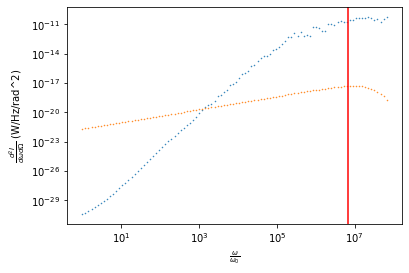

In [351]:
theta = 0
obs_tau = np.vectorize(lambda tau: np.concatenate([[c*tau], fr("m", np.array([0, 0, 0]))]), signature="()->(4)")
omega_0 = -e*sim.B_x(sim.x0)[0]/sim.u0[0]/m
time_step = omega_0 * sim.options["max_step"]
max_freq = np.pi*1e3/time_step
ratio = np.linspace(0, np.log10(max_freq)+1, 100)
ratio = np.power(10, ratio)
dIdodO = spectral_intensity(sim, obs_tau, T=1e-3)(ratio * omega_0, theta)
ax = plot(dIdodO, "$\\frac{d^2 I}{d \\omega d \\Omega}$", "W/Hz/rad^2", ratio, "$\\frac{\\omega}{\\omega_0}$", None, fig=plt.figure())
plt.xscale("log")
plt.yscale("log")
gamma = gamma_u(sim.u0)
rho = c*np.sqrt(1 - gamma**-2)/omega_0
analytic_dIdodO = analytic_spectral_intensity(ratio * omega_0, theta, gamma, rho)
plot(analytic_dIdodO, "$\\frac{d^2 I}{d \\omega d \\Omega}$", "W/Hz/rad^2", ratio, "$\\frac{\\omega}{\\omega_0}$", ax=ax)
plt.axvline(max_freq, color="red")
plt.xscale("log")
plt.yscale("log")

(0.01, 10000.0)

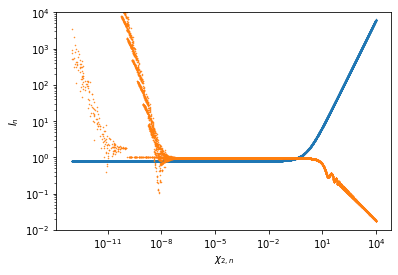

In [322]:
chi2n = np.linspace(-13, 4, 10000)
chi2n = 10**chi2n
Dtau = np.ones_like(chi2n)
u0n = np.outer(Dtau, np.array([1, 0, 0]))
taylor = taylor_intensity(Dtau, u0n, 2*u0n, Dtau, chi2n, -1)
fresnel = fresnel_intensity(Dtau, u0n, 2*u0n, Dtau, chi2n, -1)
Taylor_In = np.linalg.norm(np.vstack([taylor[0][:,0], taylor[1][:, 0]]), axis=0)
Fresnel_In = np.linalg.norm(np.vstack([fresnel[0][:,0], fresnel[1][:, 0]]), axis=0)
ax = plot(Taylor_In, "$I_n$", None, chi2n, "$\\chi_{2,n}$", None, plt.figure())
plot(Fresnel_In, "$I_n$", None, chi2n, "$\\chi_{2,n}$", None, ax=ax)
plt.xscale("log")
plt.yscale("log")
plt.ylim((1e-2, 1e4))

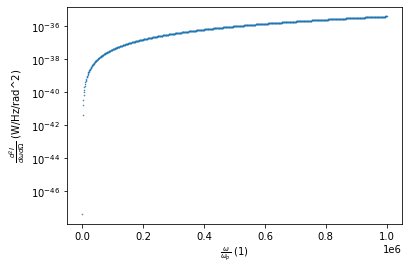

In [ ]:
plot(dIdodO, "$\\frac{d^2 I}{d \\omega d \\Omega}$", "W/Hz/rad^2", ratio, "$\\frac{\\omega}{\\omega_p}$", "1", fig=plt.figure())
plt.yscale("log")

In [ ]:
# far field
field_tensor = field_tensor_functions(E_x, B_x)[1]
F_ext, F_gen = radiation_reaction(u, x, field_tensor)
T_gen = contravariant_stress_energy(F_gen)

In [ ]:
E_gen = electric_vector(F_gen)
B_gen = magnetic_vector(F_gen)
S_gen = poynting_vector(T_gen)

In [ ]:
S_gen_mean = np.mean(S_gen, axis=0)

In [ ]:
F_generated_tau = contravariant_field_generated(fun, solution, obs_tau)
F_generated = F_generated_tau(tau)

In [ ]:
T_generated = contravariant_stress_energy(F_generated)

In [ ]:
E_generated = electric_vector(F_generated)
B_generated = magnetic_vector(F_generated)
S_generated = poynting_vector(T_generated)

In [ ]:
x_corr = x - np.tile(np.mean(x, axis=1), (x.shape[1],1)).T
u_corr = u - np.tile(np.mean(u, axis=1), (u.shape[1],1)).T

In [ ]:
M = contravariant_angular_momentum(x, m*u)

<Axes3DSubplot:xlabel='B_ext_x (T)', ylabel='B_ext_y (T)'>

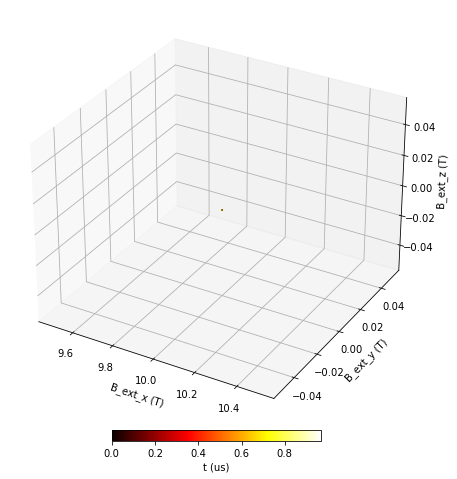

In [ ]:
plot(B, "B_ext", "T", t, "t", time_unit, fig = plt.figure(figsize=square), projection="3d")

<Axes3DSubplot:xlabel='E_ext_x (V/m)', ylabel='E_ext_y (V/m)'>

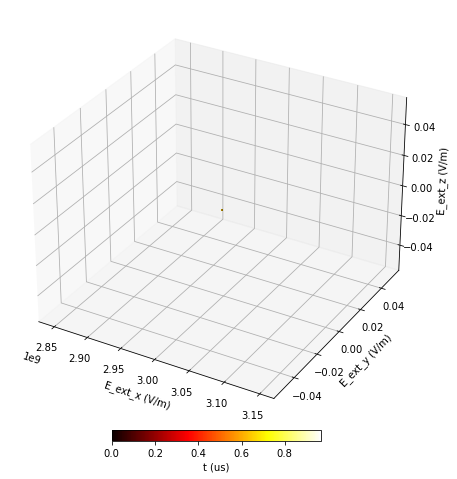

In [ ]:
plot(E, "E_ext", "V/m", t, "t", time_unit, fig = plt.figure(figsize=square), projection="3d")

<Axes3DSubplot:xlabel='B_gen_x (T)', ylabel='B_gen_y (T)'>

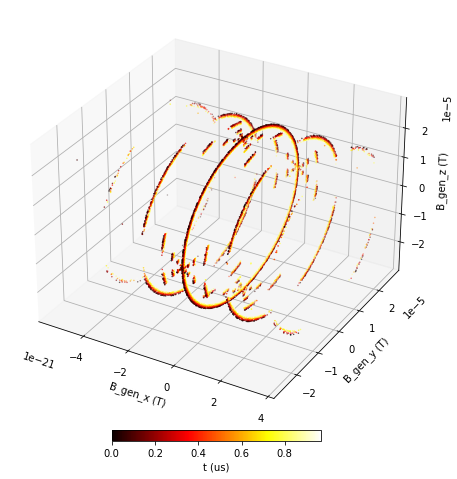

In [ ]:
plot(B_gen, "B_gen", "T", t, "t", time_unit, fig = plt.figure(figsize=square), projection="3d")

<Axes3DSubplot:xlabel='E_gen_x (V/m)', ylabel='E_gen_y (V/m)'>

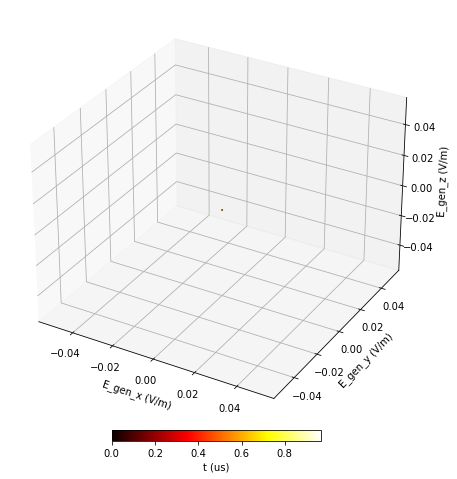

In [ ]:
plot(E_gen, "E_gen", "V/m", t, "t", time_unit, fig = plt.figure(figsize=square), projection="3d")

<Axes3DSubplot:xlabel='B_generated_x (T)', ylabel='B_generated_y (T)'>

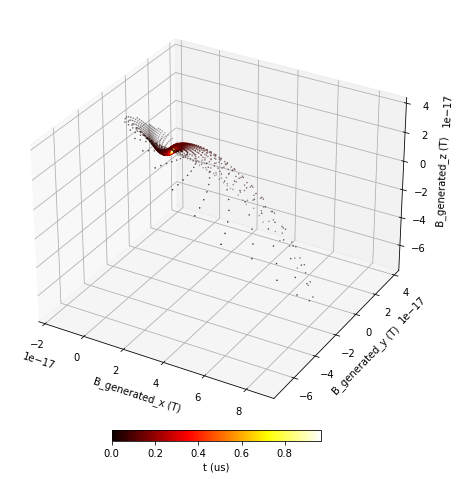

In [ ]:
plot(B_generated, "B_generated", "T", t, "t", time_unit, fig = plt.figure(figsize=square), projection="3d")

<Axes3DSubplot:xlabel='E_generated_x (V/m)', ylabel='E_generated_y (V/m)'>

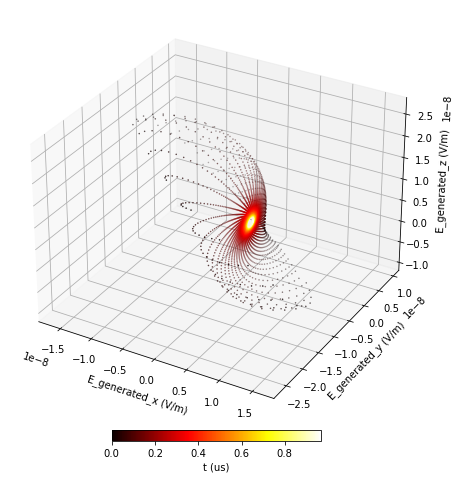

In [ ]:
plot(E_generated, "E_generated", "V/m", t, "t", time_unit, fig = plt.figure(figsize=square), projection="3d")

<Axes3DSubplot:xlabel='r_x (m)', ylabel='r_y (m)'>

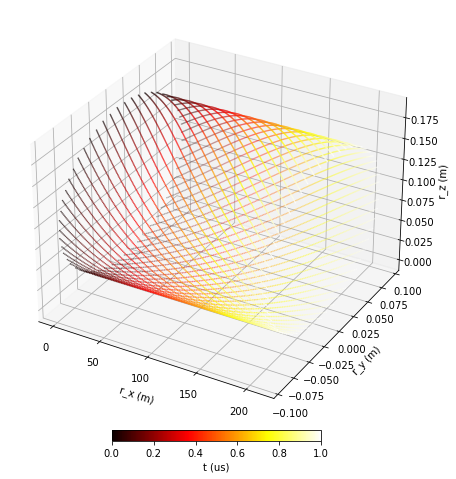

In [ ]:
plot(r, "r", "m", t, "t", time_unit, plt.figure(figsize=square), projection="3d")

<Axes3DSubplot:xlabel='v_x (m/s)', ylabel='v_y (m/s)'>

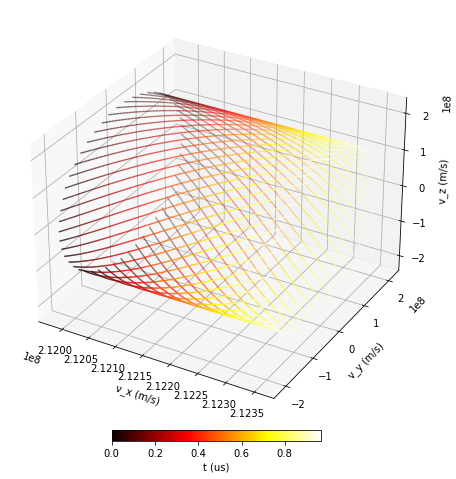

In [ ]:
plot(v, "v", "m/s", t, "t", time_unit, plt.figure(figsize=square), projection="3d")

<AxesSubplot:xlabel='t (us)', ylabel='E (MeV)'>

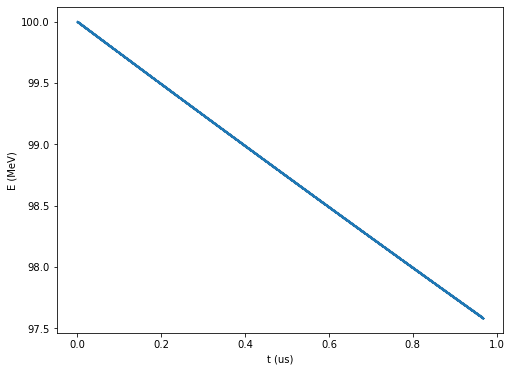

In [ ]:
plot(np.sqrt(np.linalg.norm(p, axis=-1)**2 + (m*c**2)**2), "E", "MeV", t, "t", time_unit, plt.figure(figsize=standard))

<AxesSubplot:xlabel='t (us)', ylabel='v (m/s)'>

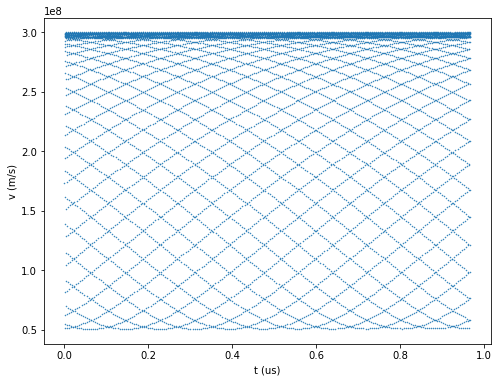

In [ ]:
plot(np.linalg.norm(v_corr, axis=-1), "v", "m/s", t, "t", time_unit, plt.figure(figsize=standard))

<AxesSubplot:xlabel='r_x (m)', ylabel='r_y (m)'>

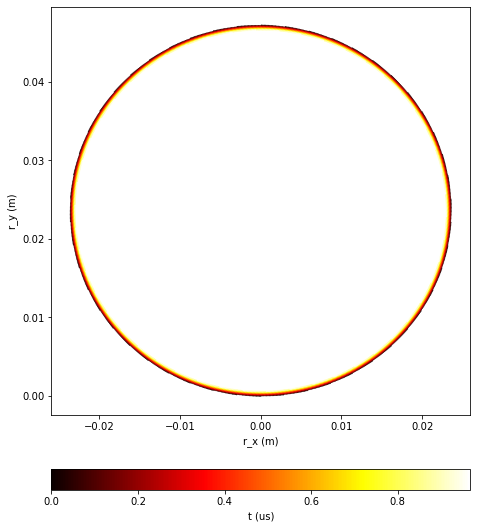

In [ ]:
plot(r[:,1:], "r", "m", t, "t", time_unit, plt.figure(figsize=square))

<AxesSubplot:xlabel='v_x (m/s)', ylabel='v_y (m/s)'>

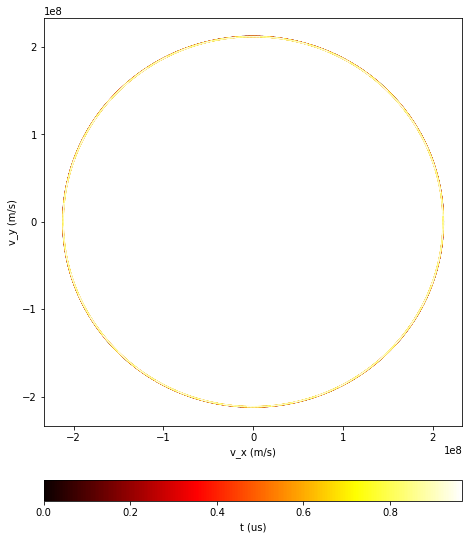

In [ ]:
plot(v[:,1:], "v", "m/s", t, "t", time_unit, plt.figure(figsize=square))